In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

In [2]:
class SmoothSoftmax1d(nn.Module):
    def __init__(self, kernel):
        super(SmoothSoftmax1d, self).__init__()
        
        kernel_ = kernel / kernel.sum()
        ks = kernel.shape[0]
        pad = int(np.floor(ks / 2))
        self.conv1 = nn.Conv1d(in_channels=1,
                               out_channels=1,
                               kernel_size=ks,
                               stride=1,
                               padding=pad,
                               padding_mode="replicate",
                               bias=False)
        
        k_ = torch.tensor([[kernel_]])
        self.conv1.weight = nn.Parameter(k_)
        self.conv1.require_grad = False
        
        self.act = nn.Softmax(dim=2)

    def forward(self, x):
        x = self.act(self.conv1(x))
        return x
    

class SmoothSoftmax2d(nn.Module):
    def __init__(self, kernel):
        super(SmoothSoftmax2d, self).__init__()
        
        assert kernel.shape[0] == kernel.shape[1], "model needs a square kernel"
        
        kernel_ = kernel / kernel.sum()
        ks = kernel.shape[0]
        pad = int(np.floor(ks / 2))
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=1,
                               kernel_size=ks,
                               stride=1,
                               padding=pad,
                               padding_mode="replicate",
                               bias=False)
        
        k_ = torch.tensor([[kernel_]])
        self.conv1.weight = nn.Parameter(k_)
        self.conv1.require_grad = False
        
        self.act = nn.Softmax(dim=2)

    def forward(self, x):
        n, c, xs, ys = x.shape
        
        x = self.conv1(x)
        
        x = x.view(-1, c*xs*ys)
        maxes = torch.max(x, 1, keepdim=True)[0]
        x_exp = torch.exp(x-maxes)
        x_exp_sum = torch.sum(x_exp, 1, keepdim=True)
        x = x_exp/x_exp_sum
        
        x = x.view(-1, c, xs, ys)
        return x


# testing 1D smooth softmax 

n:  1
6
n:  2
13
8
n:  3
17
11
4
torch.Size([3, 1, 20])


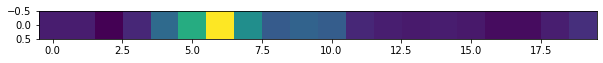

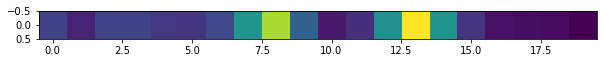

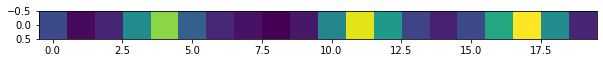

In [379]:
ss1d = SmoothSoftmax1d(kernel=np.array([0.1, 0.5, 1, 0.5, 0.1], dtype=np.float32))

n = 3
l = 20
x = 0.1 * torch.randn(n*l).reshape(n, 1, l)

for i in range(n):
    m = i + 1
    print("n: ", m)
    for j in range(m):
        ix = np.random.randint(l)
        x[i, 0, ix] = 1
        print(ix)

y = ss1d(x)
print(y.shape)


for i in range(n):
    plt.figure(figsize=(10, 5))
    y_ = y.detach().numpy()[i, 0]
    plt.imshow([y_])
    plt.show()

# testing 2D smooth softmax

torch.Size([3, 1, 10, 10])
torch.Size([3, 1, 10, 10])


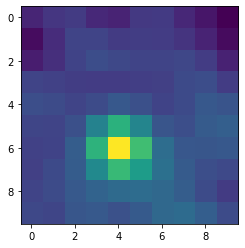

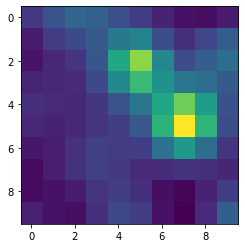

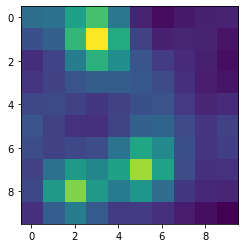

In [37]:
def gkern(l=5, sig=0.1):
    """\
    creates gaussian kernel with side length `l` and a sigma of `sig`
    """
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    return (kernel / np.sum(kernel)).astype(np.float32)

kernel = gkern(l=5, sig=1.0)

ss2d = SmoothSoftmax2d(kernel=kernel)

n = 3
l = 10
x = 0.1 * torch.randn(n*l*l).reshape(n, 1, l, l)

print(x.shape)

for i in range(n):
    m = i + 1
    for j in range(m):
        ix, iy = np.random.randint(0, l, 2)
        x[i, 0, ix, iy] = 2

y = ss2d(x)

print(y.shape)

for i in range(n):
    y_ = y.detach().numpy()[i, 0]
    plt.imshow(y_)#, vmin=0, vmax=1)
    plt.show()